In [1]:
#Import all the necessary libraries
import pandas as pd
import numpy as np
import os
from missingpy import KNNImputer
import scipy.stats as stats
from math import radians, sin, cos, acos , atan2 , sqrt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

C:\Users\abhij\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# !pip install fancyimpute
# from fancyimpute import KNN 

### Importing Data

In [3]:
# set the working directory
os.chdir(r'C:\Users\abhij\Downloads\DS\Edwisor\Cab Fare Prediction\Final')
os.getcwd()

'C:\\Users\\abhij\\Downloads\\DS\\Edwisor\\Cab Fare Prediction\\Final'

The details of data attributes in the dataset are as follows:

- **pickup_datetime** - timestamp value indicating when the cab ride started.
- **pickup_longitude** - float for longitude coordinate of where the cab ride started.
- **pickup_latitude** - float for latitude coordinate of where the cab ride started.
- **dropoff_longitude** - float for longitude coordinate of where the cab ride ended.
- **dropoff_latitude** - float for latitude coordinate of where the cab ride ended.
- **passenger_count** - an integer indicating the number of passengers in the cab ride.


predictive modeling machine learning project can be broken down into below workflow:

1. Prepare Problem a) Load libraries b) Load dataset
1. Summarize Data a) Descriptive statistics b) Data visualizations
1. Prepare Data a) Data Cleaning b) Feature Selection c) Data Transforms
1. Evaluate Algorithms a) Split-out validation dataset b) Test options and evaluation metric c) Spot Check Algorithms d) Compare Algorithms
1. Improve Accuracy a) Algorithm Tuning b) Ensembles
1. Finalize Model a) Predictions on validation dataset b) Create standalone model on entire training dataset c) Save model for later use

In [4]:
#Read the data
train_df = pd.read_csv('train_cab.csv')
test_df = pd.read_csv('test.csv')

In [5]:
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [6]:
test_df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


### Data Cleaning

In [7]:
#Train data has 16067 rows
train_len = train_df.shape[0]
train_df.shape

(16067, 7)

In [8]:
#Fare amount has one odd value '430-', which will be replaced by NaN
#We will drop any values that have fare value as less than 1
train_df.fare_amount = pd.to_numeric(train_df.fare_amount,errors='coerce')
train_df.drop(train_df.loc[train_df.fare_amount<1].index,axis=0,inplace=True)

In [9]:
#Convert the dtype of timestamp to datetime
train_df.pickup_datetime = pd.to_datetime(train_df.pickup_datetime,errors='coerce')
test_df.pickup_datetime = pd.to_datetime(test_df.pickup_datetime,errors='coerce')

####  Clean the passenger count column

In [10]:
#Look at the unique values of passenger counts and their distributions
train_df.passenger_count.value_counts()

1.00       11255
2.00        2322
5.00        1045
3.00         676
4.00         328
6.00         302
0.00          57
43.00          2
53.00          2
0.12           1
1.30           1
531.20         1
345.00         1
456.00         1
87.00          1
55.00          1
58.00          1
236.00         1
535.00         1
536.00         1
537.00         1
554.00         1
5334.00        1
35.00          1
5345.00        1
557.00         1
354.00         1
Name: passenger_count, dtype: int64

In [11]:
print(train_df[train_df.passenger_count<1].shape)
print(train_df[train_df.passenger_count>6].shape)

(58, 7)
(20, 7)


In [12]:
#Assuming a cab can accomodate at max 6 passengers at any given moment, we will replace all values above 6 as Nan   
#Also assuming a cab should have a minimum of 1 customer, any value below 1 will be dropped
train_df.drop(train_df[train_df['passenger_count']>6].index, axis=0,inplace=True)
train_df.drop(train_df[train_df['passenger_count']<1].index, axis=0,inplace=True)

#The raw data still has one odd value of 1.3 which we will replace with nan
train_df.loc[train_df.passenger_count==1.3,'passenger_count']= np.nan

train_df.passenger_count.value_counts()

1.0    11255
2.0     2322
5.0     1045
3.0      676
4.0      328
6.0      302
Name: passenger_count, dtype: int64

####  Clean the location columns (pickup/drop lat/long)

In [13]:
# Theoretical bounds of latitude and longitudes
# Latitude: -85 to +85
# Longitude: -180 to +180
position_cols = ['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude'] 
# print(train_df[position_cols].describe())

#The pickup latitude has the maximum value of 401 which is not possible. The rest of the columns
# seem to be in the theoretical bounds
train_df.loc[train_df['pickup_latitude']>85,'pickup_latitude']= np.nan
# If the lat or long value is 0 replace drop them
for col in position_cols:
    train_df.drop(train_df.loc[train_df[col]==0].index,axis=0,inplace=True)

In [14]:
# Dropping rows that have same pickup lat/long and dropoff lat/lomg
drop_index = train_df[(train_df['pickup_latitude']==train_df['dropoff_latitude']) & (train_df['pickup_longitude']==train_df['dropoff_longitude']) ].index
train_df = train_df.drop(index=drop_index).reset_index()
train_df.drop(['index'],axis=1,inplace=True)

In [15]:
#As the total number of rows is ~16,000 , NAN values can be dropped as they are in the range of ~50
train_df.isnull().sum()

fare_amount          22
pickup_datetime       1
pickup_longitude      0
pickup_latitude       1
dropoff_longitude     0
dropoff_latitude      0
passenger_count      56
dtype: int64

In [16]:
# train_df.dropna(axis=0,inplace=True)
# train_df.shape

### Missing Value Analysis

In [17]:
#calculate missing values
missing_val = pd.DataFrame(train_df.isnull().sum())
missing_val = missing_val.reset_index()
missing_val = missing_val.rename(columns = {'index': 'Variables', 0: 'count'})
missing_val['Missing_percentage'] = (missing_val['count']/len(train_df)*100)
missing_val = missing_val.sort_values('Missing_percentage', ascending = False).reset_index(drop = True)
missing_val

,Variables,count,Missing_percentage
0,passenger_count,56,0.361127
1,fare_amount,22,0.141871
2,pickup_datetime,1,0.006449
3,pickup_latitude,1,0.006449
4,pickup_longitude,0,0.000000
5,dropoff_longitude,0,0.000000
6,dropoff_latitude,0,0.000000


### Missing Value Imputation

In [18]:
train_df1 = train_df.copy()

The missing values here are either categorical or they are the target variable. We will impute the categorical data with its mode and we will not impute the target variable.
If the data is numerical we will follow the code below:

In [19]:

#imputation method 
#Actual value = -73.996335
#Mean = -73.91159739591552
#Median = -73.982061
#KNN = -73.98713000000001
# train_df1 = train_df.copy()
# train_df = train_df1.copy()

#Create missing value, a small test to identify which method is good for imputation
# train_df['pickup_longitude'].loc[10]

# train_df['pickup_longitude'].loc[10] = np.nan
# train_df['pickup_longitude'].loc[10]

#Mean Imputation
# train_df['pickup_longitude'] = train_df['pickup_longitude'].fillna(train_df['pickup_longitude'].mean())
# train_df["pickup_longitude"].loc[10]

#Median Imputation
# train_df['pickup_longitude'] = train_df['pickup_longitude'].fillna(train_df['pickup_longitude'].median())
# train_df["pickup_longitude"].loc[10]

#KNN imputation
# X = train_df[train_df.columns]
# train_df = pd.DataFrame(KNNImputer(n_neighbors=1).fit_transform(train_df), columns = train_df.columns)
# train_df["pickup_longitude"].loc[10]

In [20]:
#And for category variables imputation is done with mode
train_df['passenger_count'] = train_df['passenger_count'].fillna(int(train_df['passenger_count'].mode()))

In [21]:
#Imputing the NAs in target variables may hamper the model, so it is preferred to remove NA rows of the data
train_df=train_df.dropna(axis=0)

###  Feature Engineering

In [22]:
######extracting all the possible data from the timestamp and then dropping the timestamp column #####
def time_columns(df):
    df['year'] = df.pickup_datetime.dt.year
    df['month'] = df.pickup_datetime.dt.month
    df['day'] = df.pickup_datetime.dt.day
    # 0 is monday and 6 is sunday
    df['weekday_day'] = df.pickup_datetime.dt.weekday
    df['hour'] = df.pickup_datetime.dt.hour
    df['minutes'] = df.pickup_datetime.dt.minute
    df.drop(['pickup_datetime'],axis=1,inplace=True)
    return df

In [23]:
train_df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [24]:
train_df = time_columns(train_df)
test_df = time_columns(test_df)

In [25]:
train_df[['year','month', 'day', 'hour', 'weekday_day', 'minutes']].describe()

,year,month,day,hour,weekday_day,minutes
count,15483.000000,15483.000000,15483.000000,15483.000000,15483.000000,15483.000000
mean,2011.738746,6.271911,15.669444,13.500807,3.035846,29.678357
std,1.870159,3.448434,8.684550,6.508323,1.970017,17.299870
min,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2010.000000,3.000000,8.000000,9.000000,1.000000,15.000000
50%,2012.000000,6.000000,16.000000,14.000000,3.000000,30.000000
75%,2013.000000,9.000000,23.000000,19.000000,5.000000,45.000000
max,2015.000000,12.000000,31.000000,23.000000,6.000000,59.000000


In [26]:

############Calculate the distance between two pairs of long and lat########################
def distance(row):
    slat = row['pickup_latitude']
    slon = row['pickup_longitude']
    elat = row['dropoff_latitude']
    elon = row['dropoff_longitude']
    radius = 6371 # km
    dlat = radians(elat - slat)
    dlon = radians(elon - slon)
    a = sin(dlat/2)*sin(dlat/2) +  ( cos(radians(slat))*cos(radians(elat))*sin(dlon/2)*sin(dlon/2))
    c = 2*atan2(sqrt(a),sqrt(1-a))
    d = radius*c
    return d

###########We find the distance in km#######################
train_df['distance'] = train_df.apply(distance,axis=1)
test_df['distance'] = test_df.apply(distance,axis=1)

### Outlier Analysis

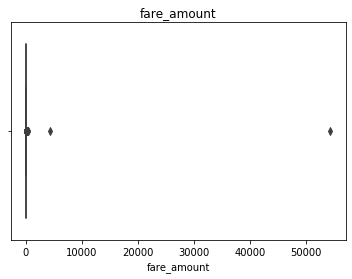

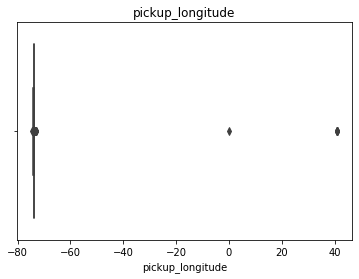

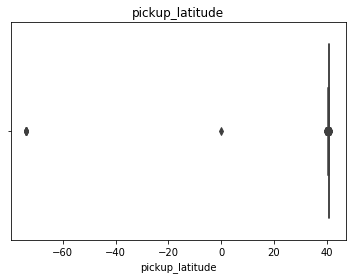

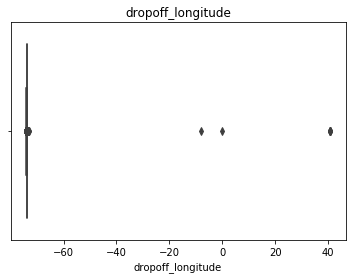

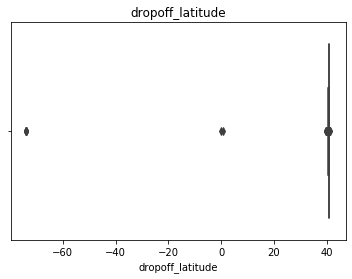

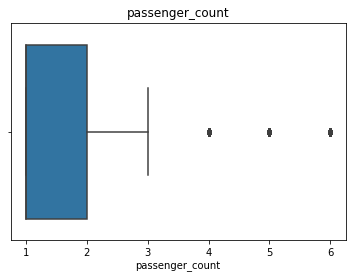

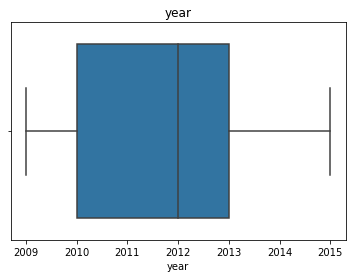

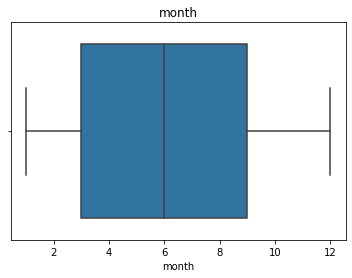

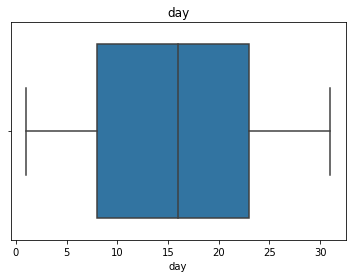

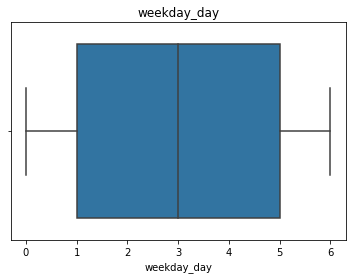

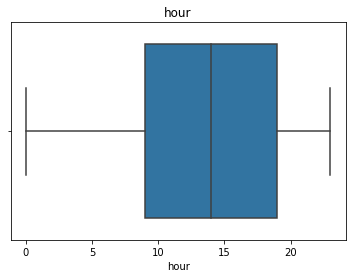

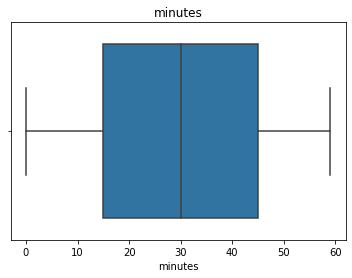

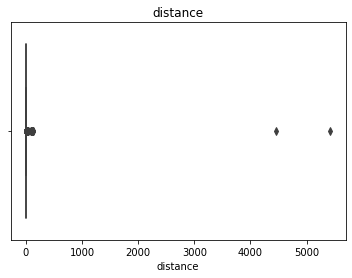

In [27]:
for col in train_df.columns:
    sns.boxplot(train_df[col])
    plt.title(col)
    plt.show()

In [28]:
#Removing values about 30 km as outlier
print(train_df.loc[train_df.distance>=30].shape[0])
train_df.drop(index = train_df[train_df.distance>=30].index,axis=0,inplace=True)

17


In [29]:
#removing the vlues where fare amount is more than 100$
print(train_df.loc[train_df.fare_amount>100].shape[0])
train_df.drop(index = train_df[train_df.fare_amount>=100].index,axis=0,inplace=True)

6


In [30]:
outlier_cols = ['distance','fare_amount']

In [31]:
out_stats = {}
for col in outlier_cols:
    #Detect and replace with NA
    #Extract quartiles
    q75, q25 = np.percentile(train_df[col], [75 ,25])

    #Calculate IQR
    iqr = q75 - q25
    # #Calculate inner and outer fence
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)
    
    low_nums = train_df.loc[train_df[col]<minimum,col].shape[0]
    high_nums = train_df.loc[train_df[col]>maximum,col].shape[0]
    out_stats.update({col:[low_nums,high_nums]})
    # #Replace with NA
    train_df.loc[train_df[col] < minimum,col] = np.nan
    train_df.loc[train_df[col] > maximum,col] = np.nan

    # #Calculate missing value
#     missing_val = pd.DataFrame(train_df.isnull().sum())
    

In [32]:
#KNN imputation
#Replace the outlier values with KNN imputation
train_df = pd.DataFrame(KNNImputer(n_neighbors=3).fit_transform(train_df), columns = train_df.columns)

C:\ProgramData\Anaconda3\lib\site-packages\missingpy\pairwise_external.py:135: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=warn_on_dtype, estimator=estimator)
C:\ProgramData\Anaconda3\lib\site-packages\missingpy\pairwise_external.py:138: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=warn_on_dtype, estimator=estimator)


In [33]:
out_stats

{'distance': [0, 1325], 'fare_amount': [0, 1336]}

###  Visualizations

In [34]:
# setting up the sns for plots
sns.set(style='darkgrid',palette='muted')

In [35]:
cat_cols = ['passenger_count','year','month','weekday_day', 'hour','day',  'minutes']
num_cols = ['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'distance']

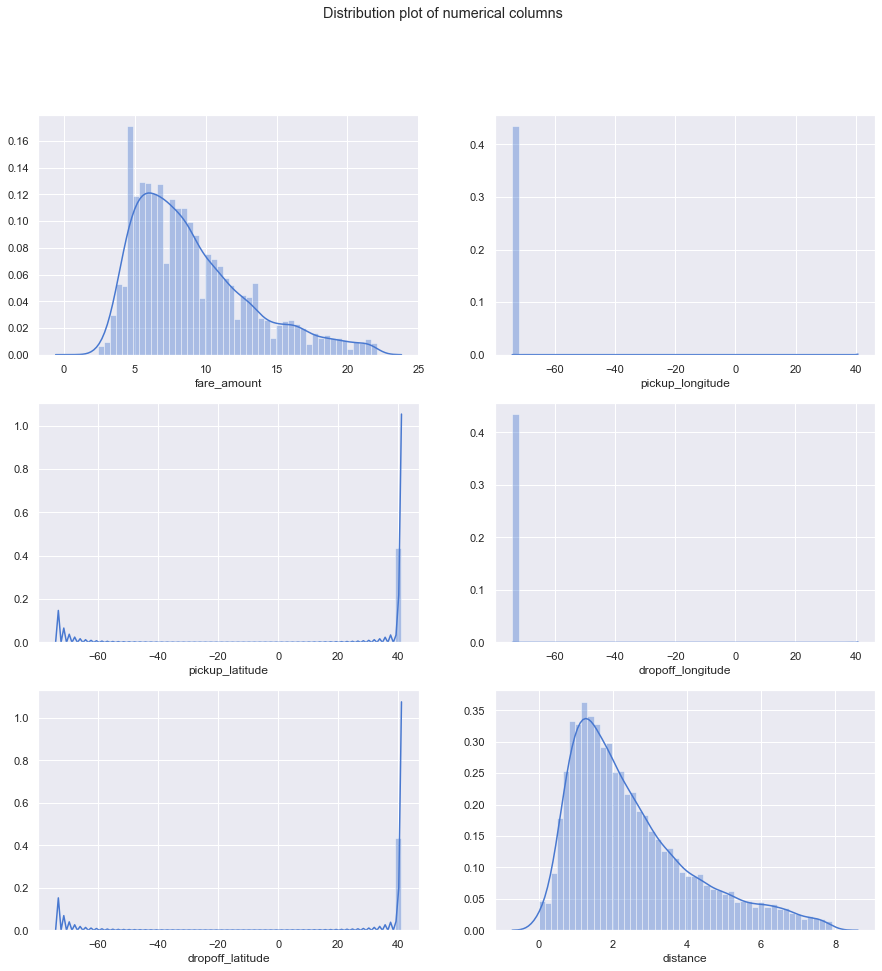

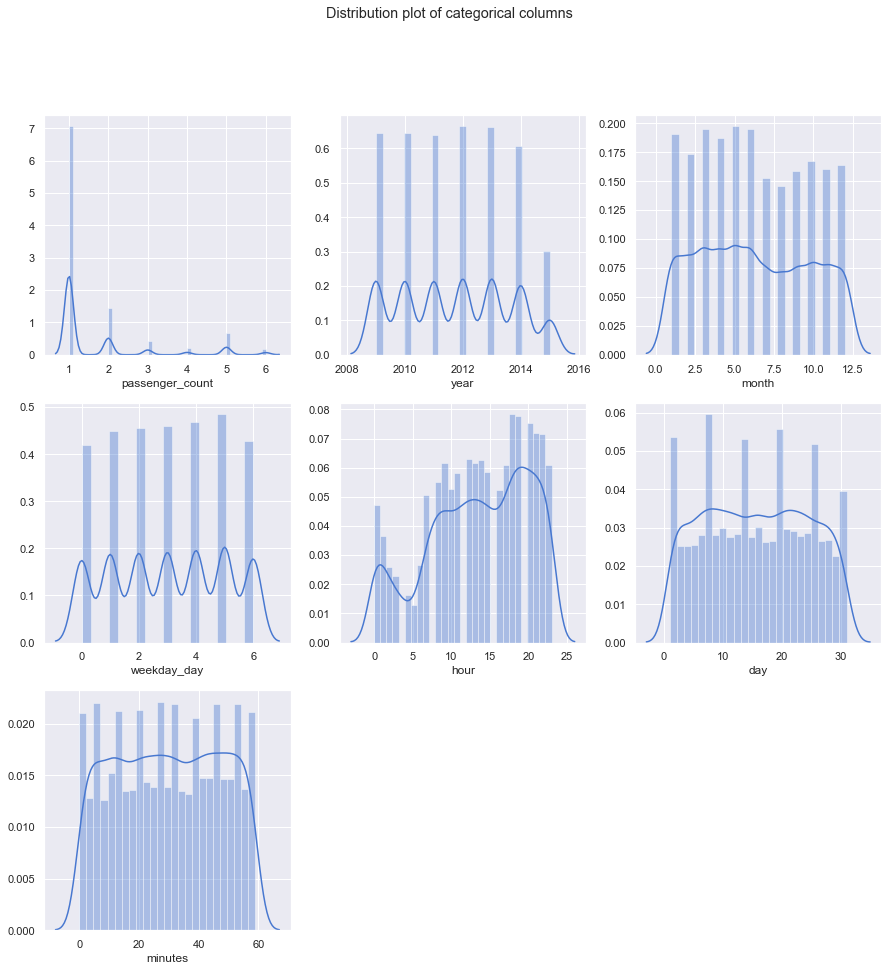

In [36]:
# Plot the distribution plots
fig = plt.figure (figsize=(15,15))
for i in range(len(num_cols)):
    plt.subplot(3,2,i+1)
    _ = sns.distplot(train_df[num_cols[i]])
fig.suptitle('Distribution plot of numerical columns')
plt.show()

fig = plt.figure(figsize=(15,15))
for i in range(len(cat_cols)):
    plt.subplot(3,3,i+1)
    _ = sns.distplot(train_df[cat_cols[i]])
fig.suptitle('Distribution plot of categorical columns')
plt.show()
    

Text(0.5, 1.0, 'Cab Fare w.r.t passenger_count')

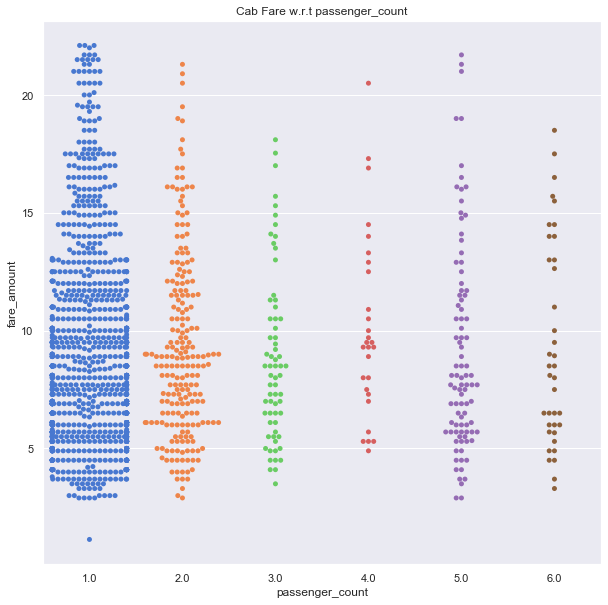

In [37]:
#Plot swarmplot
plt.figure(figsize=(10,10))
_ = sns.swarmplot(x='passenger_count',y='fare_amount',data=train_df.sample(frac=0.1))
plt.title('Cab Fare w.r.t passenger_count')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


<Figure size 1440x1440 with 0 Axes>

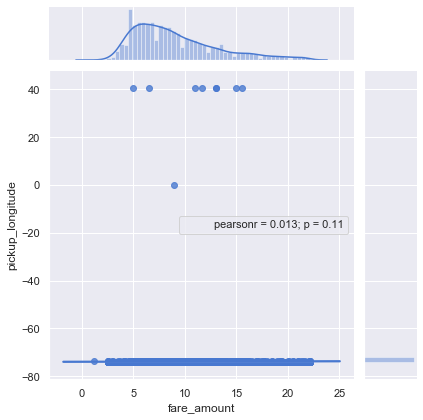

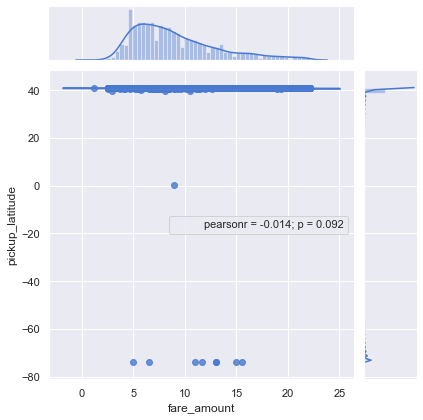

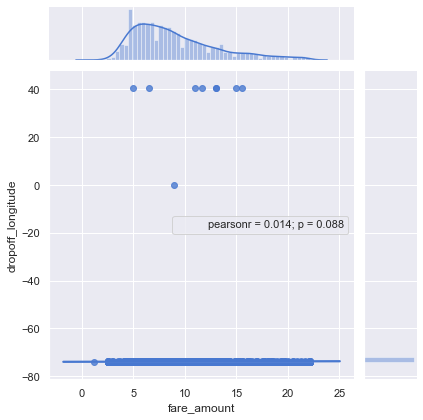

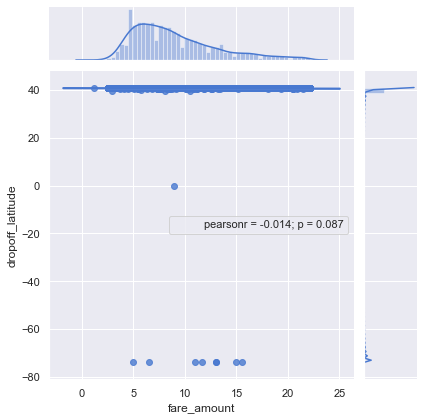

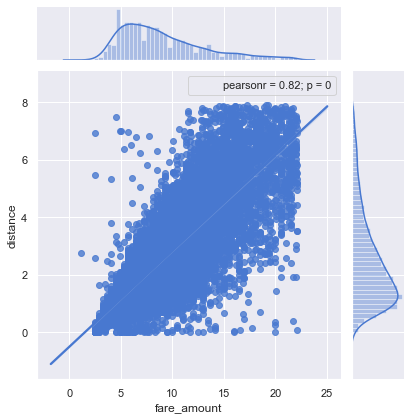

In [38]:
plt.figure(figsize= (20,20))
for i in range(1,len(num_cols)):
    _ = sns.jointplot(x='fare_amount',y=num_cols[i],data=train_df,kind = 'reg')
    _.annotate(stats.pearsonr)
    plt.show()

### Feature Selection

#### Categorical Columns

In [39]:
# Convert the necessary categorical columns from numerical to categorical
for col in cat_cols:
    train_df[col] = train_df[col].astype('int')
    if col == 'passenger_count':
        train_df[col] = train_df[col].astype('object').astype('category',ordered=True)
    else:
        train_df[col] = train_df[col].astype('object').astype('category')
for col in cat_cols:
    test_df[col] = test_df[col].astype('int')
    if col == 'passenger_count':
        test_df[col] = test_df[col].astype('object').astype('category',ordered=True)
    else:
        test_df[col] = test_df[col].astype('object').astype('category')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3325: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  exec(code_obj, self.user_global_ns, self.user_ns)


In [40]:
# XGBoost does not take categorical columns for them we have converted them back to numerical
for col in cat_cols:
    test_df[col] = test_df[col].astype('int')
    if col == 'passenger_count':
        test_df[col] = test_df[col].astype('object').astype('category',ordered=True)
    else:
        test_df[col] = test_df[col].astype('object').astype('category')

#### Feature Engineering - 2 

In [41]:
#Functions to create new features
def time_of_day(row):
    ''' for sessions in a day using hour column '''
    if (row >=5) and (row <= 11):
        return 'morning'
    elif (row >=12) and (row <=16 ):
        return 'afternoon'
    elif (row >= 17) and (row <= 20):
        return'evening'
    elif (row >=21) and (row <= 23) :
        return 'night_PM'
    elif (row >=0) and (row <=4):
        return'night_AM'
    
def season(row):
    ''' for seasons in a year using month column'''
    if (row >=3) and (row <= 5):
        return 'spring'
    elif (row >=6) and (row <=8 ):
        return 'summer'
    elif (row >= 9) and (row <= 11):
        return'fall'
    elif (row >=12)|(row <= 2) :
        return 'winter'
    
def weekend(row):
    ''' for week:weekday/weekend in a day_of_week column '''
    if (row >=0) and (row <= 4):
        return 0
    elif (row >=5) and (row <=6 ):
        return 1    

In [42]:
#Create new features for both train and test dataset
train_df['time_of_day'] = train_df['hour'].apply(time_of_day)
train_df['season'] = train_df['month'].apply(season)
train_df['weekend'] = train_df['weekday_day'].apply(weekend)

test_df['time_of_day'] = test_df['hour'].apply(time_of_day)
test_df['season'] = test_df['month'].apply(season)
test_df['weekend'] = test_df['weekday_day'].apply(weekend)

In [43]:
#One hot encoding on the categorical data
dummy_cols = ['passenger_count', 'year','time_of_day', 'season']
for col in dummy_cols:
    temp = pd.get_dummies(train_df[col],prefix = col)
    train_df = train_df.join(temp)
    temp = pd.get_dummies(test_df[col],prefix = col)
    test_df = test_df.join(temp)
del temp

In [44]:
# Drop the unneccessary columns
drop_cols = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month',  'weekday_day', 'hour', 'minutes', 
       'time_of_day', 'season', 'weekend']
train_df.drop(drop_cols,axis=1,inplace=True)
test_df.drop(drop_cols,axis=1,inplace=True)

In [45]:
num_cols = ['fare_amount','distance']
cat_cols =list( set(train_df.columns) - set(num_cols))

In [46]:
train_df[num_cols].corr()
# Distance and Fare amount have a high correlation as expected

,fare_amount,distance
fare_amount,1.000000,0.822366
distance,0.822366,1.000000


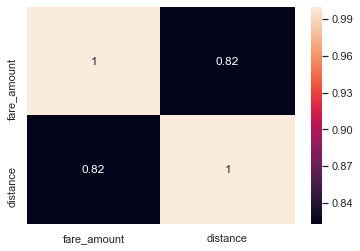

In [47]:
sns.heatmap(train_df[num_cols].corr(),annot=True)

In [48]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,15460.0,9.006415,4.063789,1.140000,6.000000,8.100000,11.000000,22.100000
distance,15460.0,2.506335,1.651912,0.000111,1.260496,2.064891,3.347295,7.902598
passenger_count_1,15460.0,0.706468,0.455395,0.000000,0.000000,1.000000,1.000000,1.000000
passenger_count_2,15460.0,0.145925,0.353042,0.000000,0.000000,0.000000,0.000000,1.000000
passenger_count_3,15460.0,0.042367,0.201432,0.000000,0.000000,0.000000,0.000000,1.000000
passenger_count_4,15460.0,0.020505,0.141723,0.000000,0.000000,0.000000,0.000000,1.000000
passenger_count_5,15460.0,0.065718,0.247796,0.000000,0.000000,0.000000,0.000000,1.000000
passenger_count_6,15460.0,0.019017,0.136588,0.000000,0.000000,0.000000,0.000000,1.000000
year_2009,15460.0,0.155045,0.361960,0.000000,0.000000,0.000000,0.000000,1.000000
year_2010,15460.0,0.154592,0.361527,0.000000,0.000000,0.000000,0.000000,1.000000


In [49]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
distance,9914.0,3.435371,3.972374,0.0,1.298277,2.217412,4.045302,99.99604
passenger_count_1,9914.0,0.697398,0.459408,0.0,0.000000,1.000000,1.000000,1.00000
passenger_count_2,9914.0,0.148679,0.355789,0.0,0.000000,0.000000,0.000000,1.00000
passenger_count_3,9914.0,0.045088,0.207507,0.0,0.000000,0.000000,0.000000,1.00000
passenger_count_4,9914.0,0.020779,0.142650,0.0,0.000000,0.000000,0.000000,1.00000
passenger_count_5,9914.0,0.070204,0.255503,0.0,0.000000,0.000000,0.000000,1.00000
passenger_count_6,9914.0,0.017854,0.132426,0.0,0.000000,0.000000,0.000000,1.00000
year_2009,9914.0,0.103087,0.304087,0.0,0.000000,0.000000,0.000000,1.00000
year_2010,9914.0,0.176821,0.381536,0.0,0.000000,0.000000,0.000000,1.00000
year_2011,9914.0,0.206778,0.405016,0.0,0.000000,0.000000,0.000000,1.00000


In [50]:
#Scale the distance column
def scale_distance(distance,max = 1,min = 0):
    scale = (max -min) / (distance.max(axis=0) - distance.min(axis=0))
    distance_scaled = scale*distance + min - distance.min(axis=0)*scale
    return distance_scaled

In [51]:
train_df.distance = scale_distance(train_df['distance'])
test_df.distance = scale_distance(test_df['distance'])

# Model Selection

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

In [53]:
#define X and Y, and split them in train and validation dataset
X = train_df[train_df.columns[1:]]
y = train_df[train_df.columns[0]]
train_x,test_x, train_y, test_y = train_test_split(X,y,test_size = 0.2)

### Linear Regression

In [54]:
#Run gridSearchCv to find the best parameters
params = { }
model_lr = linear_model.LinearRegression()
grid_cv = GridSearchCV(model_lr,params,n_jobs=-1)
grid_cv.fit(train_x,train_y)

GridSearchCV(cv=None, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=-1, param_grid={},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [55]:
grid_cv.best_params_

{}

In [56]:
model_lr = linear_model.LinearRegression(fit_intercept=True,normalize=True,n_jobs=-1)
model_lr.fit(train_x,train_y)
predicts = model_lr.predict(test_x)
print(mean_absolute_error(predicts,test_y))
print(mean_squared_error(predicts,test_y))

1.5721242992669253
5.001266793011283


### Decision Tree

In [57]:
params = {'criterion':["mse", "friedman_mse", "mae"],
         'min_samples_leaf':[1,10,50,100,500,1000],
         'max_features':['auto','sqrt','log2']
         }
model = DecisionTreeRegressor(random_state=47)
grid_cv = GridSearchCV(model,params,n_jobs=-1)
# grid_cv.fit(train_x,train_y)

In [58]:
# grid_cv.best_params_

In [59]:
model = DecisionTreeRegressor(criterion = 'mse',max_features='auto',min_samples_split=50)
model.fit(train_x,train_y)
predicts = model.predict(test_x)
print(mean_absolute_error(predicts,test_y))
print(mean_squared_error(predicts,test_y))

1.7129133001330132
5.963062667943274


### Random Forest

In [60]:
params = {'max_features' : ['auto',None,'sqrt',0.2,0.5,0.8],
         'min_samples_leaf' : [1,50,100,500,1000],
         }
model = RandomForestRegressor(n_jobs=-1,n_estimators= 500,random_state=47)
grid_cv = GridSearchCV(model,params)
# grid_cv.fit(X,y)

In [61]:
# grid_cv.best_params_

In [62]:
model = RandomForestRegressor(n_jobs=-1,n_estimators= 500,max_features=0.5,min_samples_leaf=50,random_state=47)
model.fit(train_x,train_y)
predicts = model.predict(test_x)
print(mean_absolute_error(predicts,test_y))
print(mean_squared_error(predicts,test_y))

1.5732288836197323
4.886465728299743


### XGBOOST 

In [63]:
params = {}
model = xgb.XGBRegressor(objective ='reg:linear',n_estimators=100)
#                           , colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)
grid_cv = GridSearchCV(model,params,n_jobs=-1)

In [64]:
# grid_cv.fit(train_x.drop(['day'],axis=1),train_y)

In [65]:
# grid_cv.best_params_

In [66]:
model = xgb.XGBRegressor(objective ='reg:linear',n_estimators=100,colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10)
model.fit(train_x.drop(['day'],axis=1),train_y)
predicts = model.predict(test_x.drop(['day'],axis=1))
print(mean_absolute_error(predicts,test_y))
print(mean_squared_error(predicts,test_y))

[11:11:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
1.5556842534086632
4.822351194067176


Run the model on the whole dataset

In [67]:
final_model = xgb.XGBRegressor(objective ='reg:linear',n_estimators=100,colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10)
final_model.fit(X.drop(['day'],axis=1),y)
predicts = final_model.predict(test_df.drop(['day'],axis=1))

[11:12:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


In [68]:
test_df['predicts'] = predicts

In [69]:
test_df.to_csv('XGBoost_predictions.csv')

In [81]:
a = 10
b = a
a = a/10

In [82]:
b

10